# NDWI - tide correlation analysis
## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os

import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.geo.geobox import GeoBox
from odc.ui import select_on_a_map

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides, tidal_tag, model_tides
from intertidal.elevation import (
    load_data,
    ds_to_flat,
    flat_to_ds,
)

def correlation_loop(point_id, geom, models):
    satellite_ds = load_data(
        dc=dc,
        study_area=point_id,
        geom=geom,
        time_range=(start_date, end_date),
        resolution=resolution,
        crs=crs,
        include_s2=True,
        include_ls=True,
        filter_gqa=filter_gqa,
        dask_chunks={"x": None, "y": None},
    )

    # Load data
    satellite_ds.load()

    # Model tides
    tides_df = model_tides(
        x=satellite_ds.x.mean(),
        y=satellite_ds.y.mean(),
        time=satellite_ds.time,
        model=models,
        directory=tide_model_dir,
        crs=satellite_ds.odc.crs,
    )

    # Add to data
    satellite_ds["tide_m"] = (
        tides_df.droplevel(level=["x", "y"])
        .set_index("tide_model", append=True)
        .to_xarray()
        .tide_m.reindex_like(satellite_ds)
        .transpose("tide_model", "time")
    )

    # Calculate corrs
    _, _, corr = ds_to_flat(
        satellite_ds,
        ndwi_thresh=0.0,
        min_freq=0.01,
        max_freq=0.99,
        corr_method="spearman",
    )

    corr_mask = corr.max(dim="tide_model") >= 0.15
    corr = corr.where(corr_mask)

    out_df = (
        corr.drop("spatial_ref")
        .mean(dim="z")
        .to_dataframe(name="tide_m")
        .assign(point_id=point_id)
        .set_index("point_id", append=True)
    )

    # Add percent valid intertidal pixels analysed
    out_df["valid_perc"] = corr_mask.mean(dim="z").item()

    return out_df


## Setup


### Set analysis parameters

In [3]:
# Intertidal Elevation variables
start_date = "2017"  # Informed by http://www.bom.gov.au/climate/enso/soi/?
end_date = "2019"  #  Non La Nina/El Nino period
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
# ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model_dir = "/gdata1/data/tide_models_clipped/"  # Directory containing tide model files

# Models to run
models = [
    "FES2014",
    "TPXO9-atlas-v5",
    "EOT20",
    "HAMTIDE11",
    "GOT4.10",
    "FES2012",
    "TPXO8-atlas-v1",
]

### Load correlation points

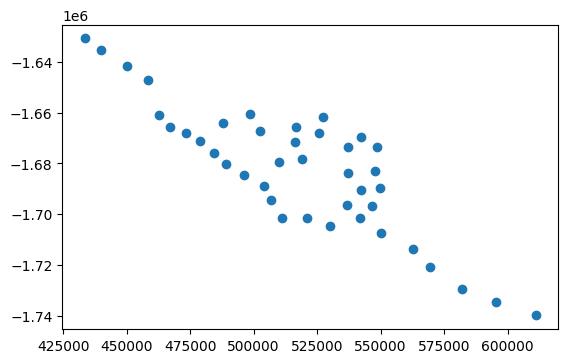

In [4]:
# Load points
points_gdf = gpd.read_file("data/raw/tide_correlation_points_input.geojson").to_crs("EPSG:3577")

# Select subset
points_gdf, name = points_gdf.cx[423112:614153,-1625174:-1752063], "spearmanndwi_nt"
# points_gdf, name = points_gdf.iloc[0:500], "robbi_part1"
# points_gdf, name = points_gdf.iloc[500:1000], "robbi_part2"
# points_gdf, name = points_gdf.iloc[1000:1500], "claire_part1"
# points_gdf, name = points_gdf.iloc[1500:2000], "claire_part2"
# points_gdf, name = points_gdf.iloc[2000:2500], "ness_part1"
# points_gdf, name = points_gdf.iloc[2500:3000], "ness_part2"
points_gdf.plot()

# Apply buffer
points_gdf["geometry"] = points_gdf.geometry.buffer(2500)


## Run correlation analysis

In [5]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

out_list = []

for i, row in tqdm(points_gdf.iterrows(), 
                   total=points_gdf.shape[0]):
    
    try:
    
        point_id = row.id
        print(f"Processing ID {point_id}")
        geom = Geometry(row.geometry, crs="EPSG:3577")       

        output_df = correlation_loop(point_id, geom, models)
        output_df["x"] = row.geometry.centroid.x
        output_df["y"] = row.geometry.centroid.y

        out_list.append(output_df)

        client.restart()
    
    except Exception as error:
        print(f"{point_id} failed; skipping. Error: {error}")

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36675,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:40947,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/35657/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:46829,


  0%|          | 0/41 [00:00<?, ?it/s]

Processing ID 21


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:16<00:00,  2.34s/it]


Reducing analysed pixels from 251001 to 16242 (6.47%)


2023-12-07 02:55:18,365 - distributed.nanny - WARNING - Restarting worker


Processing ID 22


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:17<00:00,  2.43s/it]


Reducing analysed pixels from 251001 to 20161 (8.03%)


2023-12-07 02:56:32,229 - distributed.nanny - WARNING - Restarting worker


Processing ID 153


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.19s/it]


Reducing analysed pixels from 251001 to 18628 (7.42%)


2023-12-07 02:57:42,772 - distributed.nanny - WARNING - Restarting worker


Processing ID 199


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.23s/it]


Reducing analysed pixels from 251001 to 86177 (34.33%)


2023-12-07 02:59:31,215 - distributed.nanny - WARNING - Restarting worker


Processing ID 254


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Reducing analysed pixels from 251001 to 43531 (17.34%)


2023-12-07 03:00:52,795 - distributed.nanny - WARNING - Restarting worker


Processing ID 298


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:16<00:00,  2.36s/it]


Reducing analysed pixels from 251001 to 105938 (42.21%)


2023-12-07 03:02:54,280 - distributed.nanny - WARNING - Restarting worker


Processing ID 428


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.17s/it]


Reducing analysed pixels from 251001 to 46364 (18.47%)


2023-12-07 03:04:18,250 - distributed.nanny - WARNING - Restarting worker


Processing ID 469


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


Reducing analysed pixels from 251001 to 38789 (15.45%)


2023-12-07 03:05:26,322 - distributed.nanny - WARNING - Restarting worker


Processing ID 493


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.18s/it]


Reducing analysed pixels from 251001 to 17333 (6.91%)


2023-12-07 03:06:28,936 - distributed.nanny - WARNING - Restarting worker


Processing ID 669


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


Reducing analysed pixels from 251001 to 65416 (26.06%)


2023-12-07 03:07:42,452 - distributed.nanny - WARNING - Restarting worker


Processing ID 760


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:16<00:00,  2.34s/it]


Reducing analysed pixels from 251001 to 19345 (7.71%)


2023-12-07 03:09:03,692 - distributed.nanny - WARNING - Restarting worker


Processing ID 784


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.20s/it]


Reducing analysed pixels from 251001 to 37730 (15.03%)


2023-12-07 03:10:08,216 - distributed.nanny - WARNING - Restarting worker


Processing ID 934


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.23s/it]


Reducing analysed pixels from 251001 to 24214 (9.65%)


2023-12-07 03:11:25,711 - distributed.nanny - WARNING - Restarting worker


Processing ID 965


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.23s/it]


Reducing analysed pixels from 251001 to 41520 (16.54%)


2023-12-07 03:13:00,486 - distributed.nanny - WARNING - Restarting worker


Processing ID 1048


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:16<00:00,  2.29s/it]


Reducing analysed pixels from 251001 to 44892 (17.89%)


2023-12-07 03:14:26,661 - distributed.nanny - WARNING - Restarting worker


Processing ID 1072


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.19s/it]


Reducing analysed pixels from 251001 to 63783 (25.41%)


2023-12-07 03:15:40,062 - distributed.nanny - WARNING - Restarting worker


Processing ID 1138


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.19s/it]


Reducing analysed pixels from 251001 to 28294 (11.27%)


2023-12-07 03:16:43,181 - distributed.nanny - WARNING - Restarting worker
2023-12-07 03:16:43,629 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_j3a05sa', purging


Processing ID 1177


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.22s/it]


Reducing analysed pixels from 251001 to 48250 (19.22%)


2023-12-07 03:17:54,601 - distributed.nanny - WARNING - Restarting worker


Processing ID 1180


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.22s/it]


Reducing analysed pixels from 251001 to 39332 (15.67%)


2023-12-07 03:18:58,739 - distributed.nanny - WARNING - Restarting worker


Processing ID 1328


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.21s/it]


Reducing analysed pixels from 251001 to 16618 (6.62%)


2023-12-07 03:20:09,947 - distributed.nanny - WARNING - Restarting worker


Processing ID 1538


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.25s/it]


Reducing analysed pixels from 251001 to 34496 (13.74%)


2023-12-07 03:21:40,452 - distributed.nanny - WARNING - Restarting worker


Processing ID 1589


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


Reducing analysed pixels from 251001 to 106583 (42.46%)


2023-12-07 03:23:31,247 - distributed.nanny - WARNING - Restarting worker


Processing ID 1636


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.19s/it]


Reducing analysed pixels from 251001 to 12716 (5.07%)


2023-12-07 03:24:29,366 - distributed.nanny - WARNING - Restarting worker


Processing ID 1668


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:16<00:00,  2.30s/it]


Reducing analysed pixels from 251001 to 38368 (15.29%)


2023-12-07 03:25:53,990 - distributed.nanny - WARNING - Restarting worker


Processing ID 1669


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.20s/it]


Reducing analysed pixels from 251001 to 20994 (8.36%)


2023-12-07 03:27:06,330 - distributed.nanny - WARNING - Restarting worker


Processing ID 1821


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.26s/it]


Reducing analysed pixels from 251001 to 91598 (36.49%)


2023-12-07 03:29:13,694 - distributed.nanny - WARNING - Restarting worker


Processing ID 1840


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.25s/it]


Reducing analysed pixels from 251001 to 16750 (6.67%)


2023-12-07 03:30:12,627 - distributed.nanny - WARNING - Restarting worker


Processing ID 1934


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Reducing analysed pixels from 251001 to 18931 (7.54%)


2023-12-07 03:31:30,155 - distributed.nanny - WARNING - Restarting worker


Processing ID 1963


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Reducing analysed pixels from 251001 to 6868 (2.74%)


2023-12-07 03:32:26,450 - distributed.nanny - WARNING - Restarting worker


Processing ID 2116


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.17s/it]


Reducing analysed pixels from 251001 to 54006 (21.52%)


2023-12-07 03:33:39,831 - distributed.nanny - WARNING - Restarting worker


Processing ID 2154


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: 

Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Reducing analysed pixels from 251001 to 18584 (7.40%)


2023-12-07 03:34:37,757 - distributed.nanny - WARNING - Restarting worker


Processing ID 2177


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.28s/it]


Reducing analysed pixels from 251001 to 61789 (24.62%)


2023-12-07 03:35:48,723 - distributed.nanny - WARNING - Restarting worker


Processing ID 2178


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


Reducing analysed pixels from 251001 to 13380 (5.33%)


2023-12-07 03:36:46,812 - distributed.nanny - WARNING - Restarting worker


Processing ID 2277


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.16s/it]


Reducing analysed pixels from 251001 to 18309 (7.29%)


2023-12-07 03:37:44,751 - distributed.nanny - WARNING - Restarting worker


Processing ID 2325


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:16<00:00,  2.29s/it]


Reducing analysed pixels from 251001 to 58677 (23.38%)


2023-12-07 03:39:00,188 - distributed.nanny - WARNING - Restarting worker


Processing ID 2436


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:16<00:00,  2.32s/it]


Reducing analysed pixels from 251001 to 16532 (6.59%)


2023-12-07 03:40:00,160 - distributed.nanny - WARNING - Restarting worker


Processing ID 2522


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.25s/it]


Reducing analysed pixels from 251001 to 106594 (42.47%)


2023-12-07 03:41:53,257 - distributed.nanny - WARNING - Restarting worker


Processing ID 2544


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Reducing analysed pixels from 251001 to 10379 (4.14%)


2023-12-07 03:42:51,912 - distributed.nanny - WARNING - Restarting worker


Processing ID 2793


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.18s/it]


Reducing analysed pixels from 250500 to 76274 (30.45%)


2023-12-07 03:44:47,898 - distributed.nanny - WARNING - Restarting worker


Processing ID 2821


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.18s/it]


Reducing analysed pixels from 251001 to 34319 (13.67%)


2023-12-07 03:46:06,304 - distributed.nanny - WARNING - Restarting worker


Processing ID 2904


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 7/7 [00:15<00:00,  2.18s/it]


Reducing analysed pixels from 251001 to 74397 (29.64%)


2023-12-07 03:47:33,294 - distributed.nanny - WARNING - Restarting worker


### Combine and process data

In [6]:
# Combine outputs into single dataframe
combined_df = (
    pd.concat(out_list)
    .set_index(["x", "y", "valid_perc"], append=True)
    .unstack("tide_model")["tide_m"]
    .assign(source="ndwi correlation", statistic="correlation")
    .reset_index(["x", "y", "valid_perc"])
    .reindex(["x", "y", "valid_perc", "source", "statistic"] + models, axis=1)
)

# Add additional columns
combined_df["min"] = combined_df.loc[:, models].min(axis=1)
combined_df["max"] = combined_df.loc[:, models].max(axis=1)
combined_df["diff"] = combined_df["max"] - combined_df["min"]
combined_df["ave"] = combined_df.loc[:, models].mean(axis=1)
combined_df["std"] = combined_df.loc[:, models].std(axis=1)

# Calculate ranks and best/worst models
combined_df = pd.concat(
    [combined_df, combined_df.loc[:, models].rank(axis=1).add_prefix("rank_")], axis=1
)
combined_df["top_model"] = combined_df.filter(regex='^rank').idxmax(axis=1).str[5:]
combined_df["worst_model"] = combined_df.filter(regex='^rank').idxmin(axis=1).str[5:]
combined_df

tide_model,x,y,valid_perc,source,statistic,FES2014,TPXO9-atlas-v5,EOT20,HAMTIDE11,GOT4.10,...,std,rank_FES2014,rank_TPXO9-atlas-v5,rank_EOT20,rank_HAMTIDE11,rank_GOT4.10,rank_FES2012,rank_TPXO8-atlas-v1,top_model,worst_model
point_id,,,,,,,,,,,,,,,,,,,,,
21,516442.644276,-1.671556e+06,0.998893,ndwi correlation,correlation,0.670726,0.647490,0.679817,0.618893,0.687086,...,0.026680,4.0,3.0,5.0,1.0,6.0,7.0,2.0,FES2012,HAMTIDE11
22,498432.989637,-1.660526e+06,0.970212,ndwi correlation,correlation,0.669901,0.672776,0.678625,0.638662,0.675613,...,0.017483,3.0,4.0,6.0,1.0,5.0,7.0,2.0,FES2012,HAMTIDE11
153,537163.525935,-1.683548e+06,0.980937,ndwi correlation,correlation,0.616050,0.618710,0.607304,0.571092,0.623861,...,0.020798,4.0,5.0,3.0,1.0,6.0,7.0,2.0,FES2012,HAMTIDE11
199,439899.820285,-1.635378e+06,0.970932,ndwi correlation,correlation,0.678386,0.679370,0.695030,0.603762,0.691279,...,0.047475,3.0,4.0,6.0,2.0,5.0,7.0,1.0,FES2012,TPXO8-atlas-v1
254,484566.938854,-1.675849e+06,0.510963,ndwi correlation,correlation,0.697543,0.684515,0.708324,0.650684,0.709453,...,0.039936,4.0,3.0,5.0,2.0,6.0,7.0,1.0,FES2012,TPXO8-atlas-v1
298,521114.736025,-1.701352e+06,0.871229,ndwi correlation,correlation,0.691732,0.708249,0.705356,0.642076,0.687179,...,0.022211,5.0,7.0,6.0,1.0,3.0,4.0,2.0,TPXO9-atlas-v5,HAMTIDE11
428,530032.062164,-1.704616e+06,0.815550,ndwi correlation,correlation,0.582267,0.603928,0.588071,0.522594,0.578191,...,0.025359,5.0,7.0,6.0,1.0,3.0,4.0,2.0,TPXO9-atlas-v5,HAMTIDE11
469,582028.441796,-1.729411e+06,0.918539,ndwi correlation,correlation,0.649994,0.654757,0.644533,0.600917,0.662406,...,0.020721,3.0,5.0,2.0,1.0,7.0,4.0,6.0,GOT4.10,HAMTIDE11
493,549966.678292,-1.707428e+06,0.567867,ndwi correlation,correlation,0.484439,0.485803,0.493438,0.439608,0.486596,...,0.018274,3.0,4.0,7.0,1.0,5.0,6.0,2.0,EOT20,HAMTIDE11


### Export

In [7]:
gpd.GeoDataFrame(
    data=combined_df,
    geometry=gpd.points_from_xy(combined_df.x, combined_df.y, crs="EPSG:3577"),
).to_crs("EPSG:4326").to_file(f"data/raw/tide_correlation_points_{name}.geojson")

### Combine

In [ ]:
tide_correlation_points = pd.concat(
    [
        gpd.read_file("data/raw/tide_correlation_points_robbi_part1.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_robbi_part2.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_ness_part1.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_ness_part2.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_claire_part1.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_claire_part2.geojson")
    ]
).dropna(subset="FES2014")

# Convert x/y to lat/lon
tide_correlation_points["x"] = tide_correlation_points.geometry.x
tide_correlation_points["y"] = tide_correlation_points.geometry.y

# Export
tide_correlation_points.to_file(f"data/raw/tide_correlations_2017-2019.geojson")

#### Combine with altimetry

In [ ]:
# gpd.read_file("data/raw/xtrack_rms_2017-2019.geojson")

In [ ]:
corr_spear = gpd.read_file("data/raw/tide_correlation_points_spearman.geojson").set_index("point_id")

In [ ]:
corr_pears = gpd.read_file("data/raw/tide_correlations_2017-2019.geojson").set_index("point_id")

In [ ]:
corr_pears2 = corr_pears.loc[corr_spear.index]

In [ ]:
corr_pears2.columns

In [ ]:
plt.scatter(corr_pears2['GOT4.10'], corr_spear['GOT4.10'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as pl

# Y = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
ax = sns.kdeplot(x=corr_pears2['rank_HAMTIDE11'], y=corr_spear['rank_HAMTIDE11'], fill= True, cmap = "PuBu")

In [ ]:
corr_spear[[f"rank_{m}" for m in models]]

In [ ]:
corr_spear["corr_matchup"] = corr_pears2[[f"rank_{m}" for m in models]].corrwith(corr_spear[[f"rank_{m}" for m in models]], axis=1)

In [ ]:
corr_spear.to_file(f"data/raw/tide_correlation_points_spearman2.geojson")